In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from modules.training_models import (
    infer, cv_train_model,
    lr_cv, nn_cv, rf_cv, lgb_cv, xgb_cv
)

from modules.training_utils import (
    get_indiv_important_cols, round_float_to, get_round_num,
    get_opt_val_seeds, make_country_sub, timing
)

from modules.training_optimizers import (
    get_optimized_weighted_preds_for
)

import logging

logging.basicConfig(filename='output.logs', format='%(asctime)s: %(message)s', level=logging.INFO)

In [19]:
import numpy as np
import pandas as pd
from datetime import datetime
import os

import pickle as cPickle
import glob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from collections import Counter
from bayes_opt import BayesianOptimization
from hashlib import md5


def vprint(x):
    if log_verbose:
        logging.info(x)


def prepare_test_data(X_hhold_test=None, X_indiv_cat_test=None, X_train=None, X_val=None, fill='mean'):
    # http://fastml.com/how-to-use-pd-dot-get-dummies-with-the-test-set/
    '''
    X_hhold_test: equivalent to <country_code>_hhold_test
    X_indiv_cat_test: equivalent to <country_code>_indiv_cat_test
    X_train: corresponding training dataset
    '''

    if X_val is None:
        test_index = X_hhold_test.index
        X_test = pd.concat([X_hhold_test, X_indiv_cat_test], axis=1)
        X_test = X_test.loc[test_index]
    else:
        X_test = X_val

    for col in X_train.columns.difference(X_test.columns):
        if fill == 'mean':
            X_test[col] = X_train[col].mean()
        elif fill == None:
            X_test[col] = np.nan
        else:
            raise ValueError('Unknow fill method!')

    X_test = X_test[X_train.columns]

    if fill == 'mean':
        X_test = X_test.fillna(X_train.mean())
    elif fill == None:
        # Do nothing since missing data is NaN already.
        pass
    else:
        raise ValueError('Unknow fill method!')

    return X_test


def get_train_X_y(indiv_corr_thresh):
    '''
    hhold_train, indiv_train, indiv_cat_train, and country_code are global variables!
    '''
    indiv_sample_cols = get_indiv_important_cols(indiv_train, indiv_cat_train, country_code, min_corr_val=indiv_corr_thresh)

    X_train = hhold_train.loc[indiv_cat_train.index].drop('poor', axis=1)
    y_train = np.ravel(hhold_train.loc[indiv_cat_train.index].poor)

    X_train = pd.concat([X_train, indiv_cat_train[indiv_sample_cols]], axis=1)

    return X_train, y_train


def build_data_subset(indiv_corr_thresh, opt_val_seed=1029):
    if indiv_corr_thresh >= 0:
        X_train, y_train = get_train_X_y(indiv_corr_thresh=indiv_corr_thresh)
        X_train, X_opt_val, y_train, y_opt_val = train_test_split(
           X_train, y_train, test_size=0.05, random_state=opt_val_seed, stratify=y_train
        )
    else:
        X_train, y_train = get_train_X_y(indiv_corr_thresh=0)
        X_train, X_opt_val, y_train, y_opt_val = train_test_split(
           X_train, y_train, test_size=0.05, random_state=42, stratify=y_train
        )
        X_train, X_feat_sel, y_train, y_feat_sel = train_test_split(
            X_train, y_train, test_size=0.05, random_state=opt_val_seed, stratify=y_train
        )

        feat_C = 10. ** (round(abs(indiv_corr_thresh), 1) * 10)

        br = LogisticRegression(C=feat_C, penalty='l1', random_state=42)
        br.fit(X_feat_sel, y_feat_sel)

        important_feats = X_feat_sel.columns[br.coef_[0] > 0]
        X_train = X_train[important_feats]
        
    X_train = X_train[X_train.columns[X_train.std() != 0]]
    vprint('Using {} features :: opt_val_seed {}...'.format(X_train.shape[1], opt_val_seed))
    
    return (X_train, y_train), (X_opt_val, y_opt_val)


def bayesian_optimize_model(country_code, model_type, tunable_params=None, num_iter=50, init_points=0):
    global round_num
    global is_training

    round_num = 0
    is_training = True

    store_fname = 'xgbBO_{}_res_{}_optimization_{}.dict'.format(country_code, model_type, datetime.now())
    logging.info('Bayesian optimization results will be stored in {} after training...'.format(store_fname))

    if tunable_params is None:
        if model_type == 'xgb':
            tunable_params = {
                'indiv_corr_thresh': (0, 0.3),
                'colsample_bytree': (0.2, 1),
                'max_depth': (2, 6),
                'subsample': (0.2, 1),
                'gamma': (0, 2),
                'scale_pos_weight': (0, 1),
            }
        elif model_type == 'lr':
            tunable_params = {
                'indiv_corr_thresh': (-0.9, 0.3),
                'C': (0.001, 0.6),
            }
        elif model_type == 'lgb':
            tunable_params = {
                'indiv_corr_thresh': (0, 0.4),
                'num_leaves': (4, 64),
                'colsample_bytree' : (0.2, 1),
                'subsample' : (0.2, 1),
                'min_child_samples': (2, 120),
                'scale_pos_weight': (0, 1),
            }
        elif model_type == 'nn':
            tunable_params = {
                'indiv_corr_thresh': (-0.9, 0.3),
                'l1_num': (0, 100),
                'l2_num' : (0, 100),
                'l3_num' : (0, 100),
                'alpha' : (0.005, 0.1),
            }

        elif model_type == 'rf':
            tunable_params = {
                'indiv_corr_thresh': (0, 0.4),
                'max_depth': (2, 20),
                'min_samples_split' : (2, 20),
                'min_samples_leaf' : (2, 20),
            }

    if model_type == 'xgb':
        model_predict = xgb_predict
    elif model_type == 'lr':
        model_predict = lr_predict
    elif model_type == 'lgb':
        model_predict = lgb_predict
    elif model_type == 'nn':
        model_predict = nn_predict
    elif model_type == 'rf':
        model_predict = rf_predict

    modelBO = BayesianOptimization(
        model_predict, tunable_params, verbose=bayes_opt_verbose
    )

    modelBO.maximize(init_points=init_points, n_iter=num_iter, acq="poi", xi=0.1)

    with open('./bayesian-opts-res/{:0.5}'.format(-modelBO.res['max']['max_val']) + '-' + store_fname, 'wb') as fl:
        cPickle.dump(modelBO.res, fl)

    return modelBO


def infer_test_val(
    model_id, res_name, X_train, y_oof_preds,
    X_hhold_test, X_indiv_cat_test,
    X_val, fill_type, classifiers
):
    X_test = prepare_test_data(
        X_hhold_test=X_hhold_test, X_indiv_cat_test=X_indiv_cat_test,
        X_train=X_train, fill=fill_type
    )

    test_payload = infer(model_id, res_name, X_test, fill_type, classifiers)

    payload = {
        'train': {
            '{}_{}'.format(model_id, res_name): y_oof_preds,
            'index': X_train.index
        },
        'test': test_payload
    }

    if X_val is not None:
        X_val = prepare_test_data(
            X_train=X_train, X_val=X_val, fill=fill_type
        )
        val_payload = infer(model_id, res_name, X_val, fill_type, classifiers)

        payload['val'] = val_payload

    return payload


def lr_predict(
    indiv_corr_thresh,
    C,
    class_weight=None,
    X_test=None,
    X_val=None,
    res_name=None,
    opt_val_seed=None,
    model_id='lr',
    cv_func=lr_cv,
    fill_type='mean'
):
    indiv_corr_thresh = round(indiv_corr_thresh, 2)

    if opt_val_seed is None:
        global round_num
        global opt_val_seeds
        opt_val_seed = opt_val_seeds[round_num]

    (X_train, y_train), (X_opt_val, y_opt_val) = build_data_subset(
        indiv_corr_thresh=indiv_corr_thresh, opt_val_seed=opt_val_seed
    )

    X_opt_val = prepare_test_data(
        X_train=X_train, X_val=X_opt_val, fill=fill_type
    )

    params = {}
    params['C'] = max(round(C, 2), 0.001)
    if class_weight is not None:
        params['class_weight'] = {
            0: 1.0,
            1: round(class_weight, 2),
        } if class_weight < 0.5 else None

    params['penalty'] = 'l1'

    y_oof_preds, classifiers, opt_val_loss = cv_train_model(
        X_train, y_train, X_opt_val, y_opt_val, params,
        model_id=model_id, res_name=res_name, cv_func=cv_func,
        fill_type=fill_type, cv_split=10
    )

    if X_test is not None:
        payload = infer_test_val(
            model_id=model_id, res_name=res_name,
            X_train=X_train, y_oof_preds=y_oof_preds,
            X_hhold_test=hhold_test, X_indiv_cat_test=indiv_cat_test,
            X_val=X_val,
            fill_type=fill_type,
            classifiers=classifiers
        )

        if is_training:
            round_num += 1
        return payload
    else:
        if is_training:
            round_num += 1
        return -opt_val_loss


def nn_predict(
    indiv_corr_thresh,
    l1_num,
    l2_num,
    alpha,
    l3_num=1,
    X_test=None,
    X_val=None,
    res_name=None,
    opt_val_seed=None,
    model_id='nn',
    cv_func=nn_cv,
    fill_type='mean'
):
    indiv_corr_thresh = round(indiv_corr_thresh, 2)

    if opt_val_seed is None:
        global round_num
        global opt_val_seeds
        opt_val_seed = opt_val_seeds[round_num]

    (X_train, y_train), (X_opt_val, y_opt_val) = build_data_subset(
        indiv_corr_thresh=indiv_corr_thresh, opt_val_seed=opt_val_seed
    )

    X_opt_val = prepare_test_data(
        X_train=X_train, X_val=X_opt_val, fill=fill_type
    )

    params = {
        'hidden_layer_sizes': (50, 20, 1),
        'alpha': 0.01,
        'max_iter': 1000,
        'early_stopping': True,
        'random_state': 1029
    }

    params['alpha'] = round(alpha, 2)
    params['hidden_layer_sizes'] = (get_round_num(l1_num, 10), get_round_num(l2_num, 10), get_round_num(l3_num, 5))

    y_oof_preds, classifiers, opt_val_loss = cv_train_model(
        X_train, y_train, X_opt_val, y_opt_val, params,
        model_id=model_id, res_name=res_name, cv_func=cv_func,
        fill_type=fill_type, cv_split=10
    )

    if X_test is not None:
        payload = infer_test_val(
            model_id=model_id, res_name=res_name,
            X_train=X_train, y_oof_preds=y_oof_preds,
            X_hhold_test=hhold_test, X_indiv_cat_test=indiv_cat_test,
            X_val=X_val,
            fill_type=fill_type,
            classifiers=classifiers
        )

        if is_training:
            round_num += 1
        return payload
    else:
        if is_training:
            round_num += 1
        return -opt_val_loss


def rf_predict(
    indiv_corr_thresh,
    max_depth,
    min_samples_split,
    min_samples_leaf,
    X_test=None,
    X_val=None,
    res_name=None,
    opt_val_seed=None,
    model_id='rf',
    cv_func=rf_cv,
    fill_type='mean'
):
    indiv_corr_thresh = round(indiv_corr_thresh, 2)

    if opt_val_seed is None:
        global round_num
        global opt_val_seeds
        opt_val_seed = opt_val_seeds[round_num]

    (X_train, y_train), (X_opt_val, y_opt_val) = build_data_subset(
        indiv_corr_thresh=indiv_corr_thresh, opt_val_seed=opt_val_seed
    )

    X_opt_val = prepare_test_data(
        X_train=X_train, X_val=X_opt_val, fill=fill_type
    )

    params = dict(
        max_depth=20, min_samples_split=20, min_samples_leaf=10, n_jobs=7, random_state=1029
    )

    params['max_depth'] = int(max_depth)
    params['min_samples_split'] = get_round_num(min_samples_split, 2)
    params['min_samples_leaf'] = get_round_num(min_samples_leaf, 2)

    y_oof_preds, classifiers, opt_val_loss = cv_train_model(
        X_train, y_train, X_opt_val, y_opt_val, params,
        model_id=model_id, res_name=res_name, cv_func=cv_func,
        fill_type=fill_type, cv_split=10
    )

    if X_test is not None:
        payload = infer_test_val(
            model_id=model_id, res_name=res_name,
            X_train=X_train, y_oof_preds=y_oof_preds,
            X_hhold_test=hhold_test, X_indiv_cat_test=indiv_cat_test,
            X_val=X_val,
            fill_type=fill_type,
            classifiers=classifiers
        )

        if is_training:
            round_num += 1
        return payload
    else:
        if is_training:
            round_num += 1
        return -opt_val_loss


def lgb_predict(
    indiv_corr_thresh,
    num_leaves,
    colsample_bytree,
    subsample,
    min_child_samples,
    scale_pos_weight,
    subsample_for_bin=None,
    X_test=None,
    X_val=None,
    res_name=None,
    opt_val_seed=None,
    model_id='lgb',
    cv_func=lgb_cv,
    fill_type='mean'
):
    indiv_corr_thresh = round(indiv_corr_thresh, 2)

    if opt_val_seed is None:
        global round_num
        global opt_val_seeds
        opt_val_seed = opt_val_seeds[round_num]

    (X_train, y_train), (X_opt_val, y_opt_val) = build_data_subset(
        indiv_corr_thresh=indiv_corr_thresh, opt_val_seed=opt_val_seed
    )

    X_opt_val = prepare_test_data(
        X_train=X_train, X_val=X_opt_val, fill=fill_type
    )

    params = {
        'boosting_type': 'gbdt',
        'max_depth' : -1,
        'objective': 'binary',
        'learning_rate': 0.05,
        'subsample_freq': 1,
        'scale_pos_weight': 1,
        'metric' : 'binary_error'
    }

    params['colsample_bytree'] = max(min(round(colsample_bytree, 2), 1), 0)
    params['subsample'] = max(min(round(subsample, 2), 1), 0)
    params['num_leaves'] = int(num_leaves)
    params['min_child_samples'] = int(min_child_samples)
    params['subsample_for_bin'] = int(subsample_for_bin) if subsample_for_bin is not None else 200000

    params['learning_rate'] = 0.1
    params['n_estimators'] = 10000
    params['objective'] = 'binary'
    params['random_state'] = 1029
    params['n_jobs'] = 7
    params['silent'] = True

    scale_pos_weight = 1 if scale_pos_weight > 0.5 else 1.0 * sum(y_train < 0.5) / sum(y_train > 0.5)
    params['scale_pos_weight'] = scale_pos_weight

    y_oof_preds, classifiers, opt_val_loss = cv_train_model(
        X_train, y_train, X_opt_val, y_opt_val, params,
        model_id=model_id, res_name=res_name, cv_func=cv_func,
        fill_type=fill_type, cv_split=10
    )

    if X_test is not None:
        payload = infer_test_val(
            model_id=model_id, res_name=res_name,
            X_train=X_train, y_oof_preds=y_oof_preds,
            X_hhold_test=hhold_test, X_indiv_cat_test=indiv_cat_test,
            X_val=X_val,
            fill_type=fill_type,
            classifiers=classifiers
        )

        if is_training:
            round_num += 1
        return payload
    else:
        if is_training:
            round_num += 1
        return -opt_val_loss


def xgb_predict(
    indiv_corr_thresh,
    colsample_bytree,
    max_depth,
    subsample,
    gamma,
    scale_pos_weight,
    X_test=None,
    X_val=None,
    res_name=None,
    opt_val_seed=None,
    model_id='xgb',
    cv_func=xgb_cv,
    fill_type=None
):
    '''
    DMatrix params
    - weight
    - missing (-999)

    xgboost params
    max_depth
    min_child_weight
    gamma -> minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.
    subsample -> proportion of data
    colsample_bytree -> proportion of columns used in each tree
    max_delta_step -> for imbalanced use finite value, e.g., 1

    Decrease eta and increase nrounds if overfitting is observed.
    '''
    indiv_corr_thresh = round(indiv_corr_thresh, 2)

    if opt_val_seed is None:
        global round_num
        global opt_val_seeds
        opt_val_seed = opt_val_seeds[round_num]

    (X_train, y_train), (X_opt_val, y_opt_val) = build_data_subset(
        indiv_corr_thresh=indiv_corr_thresh, opt_val_seed=opt_val_seed
    )

    X_opt_val = prepare_test_data(
        X_train=X_train, X_val=X_opt_val, fill=fill_type
    )
    
    params = {}
    params['colsample_bytree'] = max(min(round(colsample_bytree, 2), 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(round(subsample, 2), 1), 0)
    params['gamma'] = max(round(gamma, 2), 0)
    params['learning_rate'] = 0.2
    params['n_estimators'] = 10000
    params['objective'] = 'binary:logistic'
    params['random_state'] = 1029
    params['n_jobs'] = 7
    params['silent'] = True

    scale_pos_weight = 1 if scale_pos_weight > 0.5 else 1.0 * sum(y_train < 0.5) / sum(y_train > 0.5)
    params['scale_pos_weight'] = scale_pos_weight

    y_oof_preds, classifiers, opt_val_loss = cv_train_model(
        X_train, y_train, X_opt_val, y_opt_val, params,
        model_id=model_id, res_name=res_name, cv_func=cv_func,
        fill_type=fill_type, cv_split=10
    )

    if X_test is not None:
        payload = infer_test_val(
            model_id=model_id, res_name=res_name,
            X_train=X_train, y_oof_preds=y_oof_preds,
            X_hhold_test=hhold_test, X_indiv_cat_test=indiv_cat_test,
            X_val=X_val,
            fill_type=fill_type,
            classifiers=classifiers
        )

        if is_training:
            round_num += 1
        return payload
    else:
        if is_training:
            round_num += 1
        return -opt_val_loss


def predict_from_opt(country_code, model_type, num_params=10, use_latest=False, default_dir='./bayesian-opts-res/'):
    global is_training
    is_training = False

    candidate_fnames = sorted(glob.glob(os.path.join(default_dir, '*-*_{}_res_{}_*_*'.format(country_code, model_type))))

    if use_latest:
        fname = max(candidate_fnames, key=os.path.getctime)
    else:
        fname = candidate_fnames[0]

    vprint(fname)

    with open(fname, 'rb') as fl:
        res = cPickle.load(fl)

    if model_type == 'xgb':
        model_predict = xgb_predict
    elif model_type == 'lr':
        model_predict = lr_predict
    elif model_type == 'lgb':
        model_predict = lgb_predict
    elif model_type == 'nn':
        model_predict = nn_predict
    elif model_type == 'rf':
        model_predict = rf_predict

    res_df = pd.DataFrame(res['all'])
    top_res = res_df['values'].argsort().iloc[-num_params:]
    num_round_index = top_res.values[::-1]
    params = res_df.loc[top_res.values[::-1]]['params']

    model_test_preds = pd.DataFrame()
    model_train_preds = pd.DataFrame()

    for res_name, (nm_rnd, param) in enumerate(zip(num_round_index, params)):
        opt_val_seed = opt_val_seeds[nm_rnd]
        r = model_predict(X_test=True, opt_val_seed=opt_val_seed, res_name=res_name, **param)

        train_preds = pd.DataFrame(index=r['train']['index'])
        train_preds['{}_{}'.format(model_type, res_name)] = r['train']['{}_{}'.format(model_type, res_name)]

        test_preds = r['test']['{}_{}'.format(model_type, res_name)]

        if model_test_preds.empty:
            model_test_preds = test_preds
        else:
            model_test_preds = pd.concat([model_test_preds, test_preds], axis=1)

        if model_train_preds.empty:
            model_train_preds = train_preds
        else:
            model_train_preds = pd.concat([model_train_preds, train_preds], axis=1)

    return model_test_preds, model_train_preds


def load_data(country_code, data_part='train'):
    hhold = os.path.join(MWI_DATA_DIR, '{}_aligned_hhold_{}.csv'.format(country_code, data_part))
    indiv = os.path.join(MWI_DATA_DIR, '{}_aligned_indiv_{}.csv'.format(country_code, data_part))

    hhold = pd.read_csv(hhold, index_col='id')
    indiv = pd.read_csv(indiv, index_col=['id', 'iid'])

    return hhold, indiv

## Setup directories

In [5]:
# data directories
DATA_DIR = os.path.join('..', 'data')
MWI_DATA_DIR = os.path.join('..', '..', 'data', 'raw_mwi')
SUBMISSION_DIR = os.path.join('..', 'submission')
BAYESIAN_OPTS_DIR = './bayesian-opts-res'
BAYESIAN_OPTS_TEST_DIR = os.path.join(BAYESIAN_OPTS_DIR, 'bayesian-opt-test-preds')

# Setup directories
if not os.path.isdir(BAYESIAN_OPTS_DIR):
    logging.info('Creating {} directory...'.format(BAYESIAN_OPTS_DIR))
    os.mkdir(BAYESIAN_OPTS_DIR)

if not os.path.isdir(BAYESIAN_OPTS_TEST_DIR):
    logging.info('Creating {} directory...'.format(BAYESIAN_OPTS_TEST_DIR))
    os.mkdir(BAYESIAN_OPTS_TEST_DIR)

if not os.path.isdir(SUBMISSION_DIR):
    logging.info('Creating {} directory...'.format(SUBMISSION_DIR))
    os.mkdir(SUBMISSION_DIR)

## Define and initialize variables

In [6]:
bayes_opt_verbose = False  # Flag for bayes-opt logging
log_verbose = False  # Flag for miscellaneous log logging
init_points = 2  # Number of random initialization rounds (30 used in winning submission)
opt_iter = 2  # Number of bayesian optimization rounds (70 used in winning submission)

num_gen_params =  2  # Number of top meta predictions to use for blending (20 used in winning submission)

round_num = None  # Global variable to keep track of the bayesian optimization round
is_training = None  # Global variable to indicate training or testing periods

session = datetime.now()
opt_val_seeds = get_opt_val_seeds(init_points * opt_iter)  # Generation of seeds for each bayesian optimization round

model_set = ['lgb', 'lr', 'nn', 'xgb', 'rf']

opt_res = {
    'mwi': {},
}

country_preds_dict = {
    'mwi': {},
}

## Execute training and meta prediction inference

In [20]:
with timing('Full model for all countries.'):
    for country_code in ['mwi']:
        with timing('Performing training and meta predictions for country {}.'.format(country_code)):
            x_model_train_preds = pd.DataFrame()
            x_model_test_preds = pd.DataFrame()

            _, indiv_train = load_data(country_code, data_part='train')

            indiv_cat_train = pd.read_hdf(os.path.join(DATA_DIR, 'indiv_cat_train.hdf'), '{}_indiv_cat_train'.format(country_code))
            indiv_cat_test = pd.read_hdf(os.path.join(DATA_DIR, 'indiv_cat_test.hdf'), '{}_indiv_cat_test'.format(country_code))

            hhold_train = pd.read_csv(os.path.join(DATA_DIR, '{}-hhold-transformed-train.csv'.format(country_code)), index_col='id')
            hhold_test = pd.read_csv(os.path.join(DATA_DIR, '{}-hhold-transformed-test.csv'.format(country_code)), index_col='id')

            y_train = np.ravel(hhold_train.loc[indiv_cat_train.index].poor)

            with timing('Start bayesian optimization and generation of optimal sub-models for country {}'.format(country_code)):
                for ix, model_type in enumerate(model_set):
                    with timing('{}. Training bayesian opts for {} model.'.format(ix + 1, model_type)):
                        modelBO = bayesian_optimize_model(country_code=country_code, model_type=model_type, tunable_params=None, num_iter=opt_iter, init_points=init_points)
                    opt_res[country_code][model_type] = modelBO.res

            # Store optimization results
            fname = os.path.join(BAYESIAN_OPTS_DIR, 'bayesian_opt_res-{}.pkl'.format(session))
            vprint(fname)

            with open(fname, 'wb') as fl:
                cPickle.dump(opt_res, fl)

            with timing('Generate inference using the top N models based on bayesian OOF score for country {}'.format(country_code)):
                for ix, model_type in enumerate(model_set):
                    with timing('{}. Generating meta predictions for {} model.'.format(ix + 1, model_type)):
                        model_test_preds, model_train_preds = predict_from_opt(
                            country_code, model_type, num_params=num_gen_params,
                            use_latest=True, default_dir=BAYESIAN_OPTS_DIR
                        )

                        model_test_preds.to_hdf(
                            os.path.join(BAYESIAN_OPTS_TEST_DIR, 'model_test_preds-{}.hdf'.format(session)),
                            'model_test_preds_{}_{}'.format(country_code, model_type)
                        )

                        model_train_preds.to_hdf(
                            os.path.join(BAYESIAN_OPTS_TEST_DIR, 'model_train_preds-{}.hdf'.format(session)),
                            'model_train_preds{}_{}'.format(country_code, model_type)
                        )

                        # Collect meta predictions
                        x_model_train_preds = pd.concat([x_model_train_preds, model_train_preds], axis=1)
                        x_model_test_preds = pd.concat([x_model_test_preds, model_test_preds], axis=1)

            country_preds_dict[country_code]['train'] = x_model_train_preds
            country_preds_dict[country_code]['test'] = x_model_test_preds
            country_preds_dict[country_code]['y_train'] = hhold_train.loc[x_model_train_preds.index].poor.values

Fragment [1. Training bayesian opts for lgb model.] done in 35.26 s

Fragment [2. Training bayesian opts for lr model.] done in 55.62 s

Fragment [3. Training bayesian opts for nn model.] done in 43.26 s

Fragment [4. Training bayesian opts for xgb model.] done in 182.21 s

Fragment [5. Training bayesian opts for rf model.] done in 23.70 s

Fragment [Start bayesian optimization and generation of optimal sub-models for country mwi] done in 340.05 s

Fragment [1. Generating meta predictions for lgb model.] done in 17.91 s

Fragment [2. Generating meta predictions for lr model.] done in 21.56 s

Fragment [3. Generating meta predictions for nn model.] done in 12.58 s

Fragment [4. Generating meta predictions for xgb model.] done in 146.08 s

Fragment [5. Generating meta predictions for rf model.] done in 13.72 s

Fragment [Generate inference using the top N models based on bayesian OOF score for country mwi] done in 211.86 s

Fragment [Performing training and meta predictions for country m

## Perform OOF optimized blending

In [21]:
median_weight_optimized_preds_sub = []
mean_weight_optimized_preds_sub = []

for country_code in ['mwi']:
    with timing('Optimizing meta prediction weights for country {}.'.format(country_code)):
        x_test_median_preds, x_test_mean_preds, x_optimized_weights_preds, x_coeffs = get_optimized_weighted_preds_for(country_preds_dict, country_code)

    median_weight_optimized_preds_sub.append(make_country_sub(x_test_median_preds, x_test_median_preds, country_code))
    mean_weight_optimized_preds_sub.append(make_country_sub(x_test_mean_preds, x_test_mean_preds, country_code))

median_weight_optimized_preds_sub = pd.concat(median_weight_optimized_preds_sub)
mean_weight_optimized_preds_sub = pd.concat(mean_weight_optimized_preds_sub)


date_now = datetime.now()
median_sub_fname = os.path.join(SUBMISSION_DIR, 'submission-test-median-agg-models-{}.csv'.format(date_now))
mean_sub_fname = os.path.join(SUBMISSION_DIR, 'submission-test-mean-agg-models-{}.csv'.format(date_now))

logging.info(median_sub_fname)
logging.info(mean_sub_fname)

median_weight_optimized_preds_sub.to_csv(median_sub_fname)
mean_weight_optimized_preds_sub.to_csv(mean_sub_fname)

0.2984074130677218
0.2979799572477056
0.30018553524182306
0.3009378240836755
0.30145900492820055
0.30044315099320046
0.29813375671015996
0.29960457585837386
0.2999125330821543
0.2976273525330935
0.29983243738230053 0.29948640458589687
Fragment [Optimizing meta prediction weights for country mwi.] done in 3.66 s



country
mwi    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

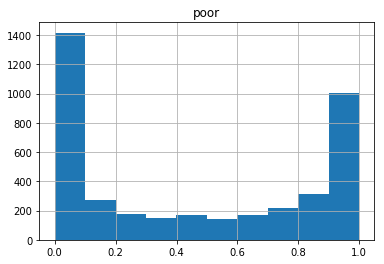

In [22]:
median_weight_optimized_preds_sub.groupby('country').hist()

country
mwi    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

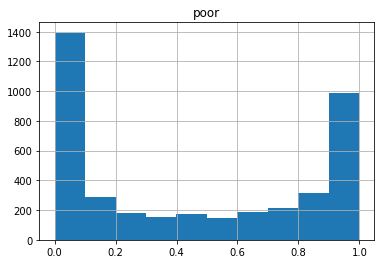

In [23]:
mean_weight_optimized_preds_sub.groupby('country').hist()